In [1]:
import tensorflow as tf

from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import ReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\Yash\anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
df = pd.read_csv('syam.csv', index_col=0)

In [3]:
X = df.iloc[:, :100*100].values.reshape(-1, 100, 100, 1) 
y = df.iloc[:, -1].values

In [4]:
X.shape, y.shape

((10, 100, 100, 1), (10,))

In [5]:
y = to_categorical(y, num_classes= 1+ df.loc[:, 'class'].unique().shape[0])

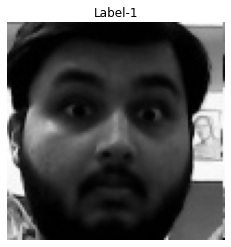

In [6]:
#q = np.random.randint(100*100)
plt.imshow(X[9][:,:,0], cmap='gray')
plt.title(f'Label-{np.argmax(y[9])}')
plt.axis('off')
plt.show()

In [7]:
X_train,X_test,y_train,y_test=train_test_split(X, y, random_state=42, test_size=0.15)

print(f'Train Size - {X_train.shape}\nTest Size - {X_test.shape}')

Train Size - (8, 100, 100, 1)
Test Size - (2, 100, 100, 1)


In [19]:
y_test

array([[0., 1.],
       [0., 1.]], dtype=float32)

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=10,
                                   width_shift_range=0.25,
                                   height_shift_range=0.25,
                                   shear_range=0.1,
                                   zoom_range=0.25,
                                   horizontal_flip=False)

valid_datagen = ImageDataGenerator(rescale=1./255.)

In [9]:
from datetime import datetime 

In [10]:
num_classes = 4
model_name = 'Face_trained_model_'+datetime.now().strftime("%H_%M_%S_")

In [11]:
model = Sequential(name = model_name)

model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(100, 100, 1)))
model.add(BatchNormalization()) #----------------
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(BatchNormalization()) #----------------
model.add(Conv2D(64, kernel_size=5, padding='same', activation='relu'))
model.add(BatchNormalization()) #----------------
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2)) #----------------

model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=5, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "Face_trained_model_19_51_26_"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 98, 98, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        102464    
_________________________________________________________________
batch_normalization_2 (Batch (None, 96, 96, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48

In [13]:
learning_rate = 0.001
optimizer = RMSprop(lr=learning_rate)

model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=200,
                                            verbose=1,
                                            factor=0.2)

ch = ModelCheckpoint('models/'+model_name+'.h5', monitor='val_acc', verbose=0, save_best_only=True, mode='max')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=200)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/"+datetime.now().strftime("%Y%m%d-%H%M%S"))

In [25]:
X_train.shape[0]

8

In [26]:
epochs = 50
batch_size = 2
history = model.fit_generator(train_datagen.flow(X_train, y_train, batch_size=batch_size),
                              steps_per_epoch= X_train.shape[0]//batch_size,
                              epochs=epochs,
                              validation_data=valid_datagen.flow(X_test, y_test),
                              validation_steps=50,
                              verbose = 1,
                              callbacks=[learning_rate_reduction, es, ch, tensorboard_callback])

Epoch 1/50


InvalidArgumentError:  logits and labels must be broadcastable: logits_size=[2,5] labels_size=[2,2]
	 [[node categorical_crossentropy/softmax_cross_entropy_with_logits (defined at <ipython-input-26-7d914abcd15f>:3) ]] [Op:__inference_train_function_3467]

Function call stack:
train_function


In [27]:
import joblib

In [28]:
joblib.dump(model, 'model.pkl')

TypeError: cannot pickle 'weakref' object

In [29]:
import pickle
 
# Save the trained model as a pickle string.
saved_model = pickle.dumps(model)

TypeError: cannot pickle 'weakref' object

In [30]:
from keras.models import load_model

model.save('model2.h5')